In [ ]:
import sys
import os
from itertools import combinations

dir_notebook = os.path.dirname(os.path.abspath("__file__"))
dir_parent = os.path.dirname(dir_notebook)
if not dir_parent in sys.path:
    sys.path.append(dir_parent)

from PyQt5.QtWidgets import QMainWindow, QWidget, QGridLayout, QVBoxLayout, QHBoxLayout, QApplication, QMessageBox, QDialog
from optic.config.constants import AccessURL, Extension
from optic.controls.view_control import ViewControl
from optic.controls.table_control import TableControl
from optic.dialog.elastix_params_config import ElastixParamsConfigDialog
from optic.gui.app_setup import setupMainWindow
from optic.gui.app_style import applyAppStyle
from optic.gui.slider_layouts import makeLayoutContrastSlider, makeLayoutOpacitySlider
from optic.gui.io_layouts import makeLayoutLoadFileWidget, makeLayoutLoadFileExitHelp, makeLayoutROITrackingIO
from optic.gui.processing_image_layouts import makeLayoutMicrogliaXYCTStackRegistration
from optic.gui.processing_roi_layouts import (
    makeLayoutROIMatching, makeLayoutROIMatchingTest, makeLayoutROIManagerForTable, makeLayoutROIEditConfig,
    makeLayoutCellpose, makeLayoutROIManager
)
from optic.gui.view_layouts import (
    makeLayoutViewWithZTSlider
)
from optic.manager import WidgetManager, ConfigManager, DataManager, ControlManager, LayoutManager, initManagers
from optic.gui.bind_func import (
    bindFuncExit, bindFuncButtonsROIManagerForTable, bindFuncButtonRunElastixForMicrogliaXYCTStackRegistration,
    bindFuncLoadFileWidget, bindFuncSliderSpinBoxROIEditConfig, bindFuncPlaneTSliderWithXYCTTracking,
    bindFuncTableSelectionChangedWithTracking, bindFuncTableCellChangedWithMicrogliaTracking,
    bindFuncOpacitySlider, bindFuncROIMaskNpyIO, bindFuncROIManagerZipIO,
    bindFuncHighlightOpacitySlider, bindFuncBackgroundContrastSlider, bindFuncBackgroundVisibilityCheckbox, 
    bindFuncViewEvents, bindFuncHelp, bindFuncCheckboxShowMatchedROI,
    bindFuncCheckboxShowROIPair, bindFuncROIPairOpacitySlider, bindFuncButtonSaveRegisterdImage,
    bindFuncButtonRunROIMatchingForXYCT, bindFuncButtonClearROIMatching,
    bindFuncButtonRunCellposeForXYCT, bindFuncMicrogliaTrackingIO,
    bindFuncCheckboxShowRegisteredROIImage, bindFuncCheckboxShowRegisteredStack
)
from optic.utils.layout_utils import clearLayout

class MicrogliaTrackingGUI(QMainWindow):
    def __init__(self):
        APP_NAME = "MICROGLIA_TRACKING"
        QMainWindow.__init__(self)
        self.widget_manager, self.config_manager, self.data_manager, self.control_manager, self.layout_manager = initManagers(
            WidgetManager(), ConfigManager(), DataManager(), ControlManager(), LayoutManager()
        )
        self.config_manager.setCurrentApp(APP_NAME)
        self.app_keys = self.config_manager.gui_defaults["APP_KEYS"]

        self.setupUI_done = False
        setupMainWindow(self, self.config_manager.gui_defaults)

        self.initUI()

    """
    setup UI Function
    """
    def initUI(self):
        self.central_widget = QWidget(self)
        self.setCentralWidget(self.central_widget)
        self.layout_main = QGridLayout(self.central_widget)

        # file load UI
        self.layout_file_load = QHBoxLayout()
        self.setupFileLoadUI()
        self.layout_main.addLayout(self.layout_file_load, 1, 0, 1, 1)

        # main UI
        self.layout_main_ui = QGridLayout()
        self.layout_main.addLayout(self.layout_main_ui, 0, 0, 1, 2)
        # extra UI (bottom)
        self.layout_extra_ui = QHBoxLayout()
        self.layout_main.addLayout(self.layout_extra_ui, 1, 1, 1, 1)

    def setupFileLoadUI(self):
        file_load_widget = QWidget()
        layout = QVBoxLayout(file_load_widget)

        layout.addLayout(self.makeLayoutSectionBottom())
        # bindFunc
        self.bindFuncFileLoadUI()

        self.layout_file_load.addWidget(file_load_widget)

    def loadFilePathsandInitialize(self):
        self.control_manager, self.data_manager = initManagers(self.control_manager, self.data_manager)
        success, e = self.loadData()
        if success:
            QMessageBox.information(self, "File load", "File loaded successfully!")
            self.setupMainUI()
        else:
            QMessageBox.warning(self, "File Load Error", f"Failed to load the file. \n {e}")
            return

    def setupMainUI(self):
        if self.setupUI_done:
            # clear layouts
            clearLayout(self.layout_main_ui)
            clearLayout(self.layout_extra_ui)
        
        # set up main UI
        self.setupMainUILayouts()
        self.setupControls()
        self.bindFuncAllWidget()
        self.initializeDataControlForXYCT()

        self.setupUI_done = True

    def loadData(self):
        for app_key in self.app_keys:
            success, e = self.data_manager.loadTiffStack(
                app_key=app_key, 
                path_tiff=self.widget_manager.dict_lineedit[f"path_tiff"].text()
            )
        return success, e

    def setupMainUILayouts(self):
        self.layout_main_ui.addLayout(self.makeLayoutSectionLeftUpper(), 0, 0, 1, 1)
        self.layout_main_ui.addLayout(self.makeLayoutSectionRightUpper(), 0, 1, 1, 1)
        self.layout_extra_ui.addLayout(self.makeLayoutSectionBottomExtra())

    def setupControls(self):
        for app_key in self.app_keys:
            self.control_manager.table_controls[app_key] = TableControl(
                app_key=app_key,
                q_table=self.widget_manager.dict_table[app_key],
                data_manager=self.data_manager,
                widget_manager=self.widget_manager,
                config_manager=self.config_manager,
                control_manager=self.control_manager,
            )
            self.control_manager.table_controls[app_key].setupWidgetDynamicTable(app_key)

            self.control_manager.view_controls[app_key] = ViewControl(
                app_key=app_key,
                q_view=self.widget_manager.dict_view[app_key], 
                q_scene=self.widget_manager.dict_scene[app_key], 
                data_manager=self.data_manager, 
                widget_manager=self.widget_manager,
                config_manager=self.config_manager,
                control_manager=self.control_manager,
                app_key_sec=self.app_keys[1] if app_key == self.app_keys[0] else None # only "pri" app_key has sec app_key
            )
            # self.control_manager.view_controls[app_key].setViewSize()
            # self.control_manager.view_controls[app_key].setShowRegImROI(False)
            # self.control_manager.view_controls[app_key].setShowRegStack(False)

        # set "sec" view's slider to "1"
        self.widget_manager.dict_slider[f"{self.app_keys[1]}_plane_t"].setValue(1)
        self.control_manager.view_controls[self.app_keys[1]].setPlaneT(1)
        self.control_manager.table_controls[self.app_keys[1]].setPlaneT(1)

    # for XYCT data, control
    def initializeDataControlForXYCT(self):
        for plane_t in range(self.data_manager.getSizeOfT(self.app_keys[0])):
            self.data_manager.dict_roi_coords_xyct[plane_t] = {}
            self.data_manager.dict_roi_coords_xyct_reg[plane_t] = {}
            self.data_manager.dict_roi_matching["id"][plane_t] = []
            for app_key in self.app_keys:
                self.control_manager.view_controls[app_key].roi_colors_xyct[plane_t] = {}

        list_plane_combi = list(combinations(range(self.data_manager.getSizeOfT(self.app_keys[0])), 2))
        for plane_pri, plane_sec in list_plane_combi:
            # Initialize the nested dictionaries if not already present
            if plane_pri not in self.data_manager.dict_roi_matching["match"]:
                self.data_manager.dict_roi_matching["match"][plane_pri] = {}
            if plane_sec not in self.data_manager.dict_roi_matching["match"][plane_pri]:
                self.data_manager.dict_roi_matching["match"][plane_pri][plane_sec] = {}


    """
    makeLayout Function; Component
    小要素のLayout
    return -> Layout
    """

    "Bottom"
    def makeLayoutComponentFileLoadUI(self):
        layout = QVBoxLayout()
        # Label
        layout.addWidget(self.widget_manager.makeWidgetLabel(key="load_tiff", label="File Load", font_size=12, bold=True, italic=True, use_global_style=False))
        # LineEdit
        key = "path_tiff"
        layout.addLayout(makeLayoutLoadFileWidget(self.widget_manager, label="tiff stack (XYCT) file path", key_label=key, key_lineedit=key, key_button=key))
        # Button
        layout.addLayout(makeLayoutLoadFileExitHelp(self.widget_manager))
        return layout

    "Left/Right Upper"
    # XYCT tiff stack view, slider
    def makeLayoutComponentImageView(self, app_key):
        layout = makeLayoutViewWithZTSlider(
            self.widget_manager, 
            app_key,
            slider_z=False,
            slider_t=True,
            key_label_t=f"{app_key}_plane_t",
            key_slider_t=f"{app_key}_plane_t",
            stack_size_t=self.data_manager.getSizeOfT(app_key),
            )
        return layout
    
    # channel contrast, ROI opacity slider
    def makeLayoutComponentContrastOpacitySlider(self, app_key):
        layout = QVBoxLayout()
        channels = self.config_manager.gui_defaults["CHANNELS"]
        layout_channel = QHBoxLayout()
        for channel in channels:
            layout_channel.addLayout(makeLayoutContrastSlider(
                self.widget_manager, 
                key_label=f"{app_key}_{channel}", 
                key_checkbox=f"{app_key}_{channel}", 
                key_slider=f"{app_key}_{channel}", 
                label_checkbox=f"Show {channel} channel", 
                label_label=f"{channel} Value", 
                checked=True
            ))

        layout.addLayout(layout_channel)
        layout.addLayout(makeLayoutOpacitySlider(
            self.widget_manager, 
            key_label=app_key, 
            key_slider=app_key, 
            label=app_key
        ))
        return layout

    # Table, ROI IO
    def makeLayoutComponentTable_Button(self, app_key):
        layout = QVBoxLayout()
        layout.addWidget(self.widget_manager.makeWidgetTable(app_key))
        layout.addLayout(makeLayoutROIManagerForTable(
            self.widget_manager,
            key_button_roi_add=f"{app_key}_roi_add",
            key_button_roi_remove=f"{app_key}_roi_remove",
            key_button_roi_edit=f"{app_key}_roi_edit",
        ))
        layout.addLayout(makeLayoutROIEditConfig(
            self.widget_manager,
            key_label_roi_opacity=f"{app_key}_opacity_roi_edit",
            key_label_pen_radius=f"{app_key}_pen_radius",
            key_slider_roi_opacity=f"{app_key}_opacity_roi_edit",
            key_spinbox_pen_radius=f"{app_key}_pen_radius",
        ))
        return layout
    
    # View, slider
    def makeLayoutComponent_View_Slider(self, app_key):
        layout = QVBoxLayout()
        layout.addLayout(self.makeLayoutComponentImageView(app_key))
        layout.addLayout(self.makeLayoutComponentContrastOpacitySlider(app_key))
        return layout
    
    "Bottom Extra"
    # Image Registration
    def makeLayoutComponenImageRegistration(self):
        layout = makeLayoutMicrogliaXYCTStackRegistration(
            self.widget_manager,
            self.data_manager.getSizeOfC(self.app_keys[0]),
            self.data_manager.getSizeOfT(self.app_keys[0]),               
            f"elastix_registration",
            f"elastix_ref_c",
            f"elastix_ref_plane_t",
            f"opacity_roi_pair",
            f"elastix_method",
            f"elastix_ref_c",
            f"elastix_ref_plane_t",          
            f"elastix_config", 
            f"elastix_run_t",   
            f"export_reg_tiff",
            f"show_roi_match",
            f"show_roi_pair",
            f"show_reg_stack",
            f"show_reg_im_roi",
            f"opacity_roi_pair",
        )
        return layout
    
    # Optimal Transport ROI Matching
    def makeLayoutComponentROIMatching(self):
        layout = QVBoxLayout()
        layout.addLayout(makeLayoutROIMatching(
            self.widget_manager,
            "roi_matching",
            "ot_method",
            "ot_partial_mass",
            "ot_partial_reg",
            "ot_dist_exp",
            "ot_threshold_transport",
            "ot_threshold_cost",
            "ot_partial_mass",
            "ot_partial_reg",
            "ot_dist_exp",
            "ot_threshold_transport",
            "ot_threshold_cost",
            "ot_method",
            "ot_run",
            "ot_clear",
        ))
        layout.addWidget(self.widget_manager.makeWidgetButton("ot_run_all_tplanes", "Run Optimal Transport for all t-planes"))
        layout.addLayout(makeLayoutROIMatchingTest(
            self.widget_manager,
            "roi_matching_test",
        ))
        layout.addLayout(makeLayoutROITrackingIO(
            self.widget_manager,
            "roi_matching_save",
            "roi_matching_load",
        ))
        return layout
    
    # ROI Manager
    def makeLayoutComponentCellposeROIManager(self):
        layout = QVBoxLayout()
        layout.addLayout(makeLayoutCellpose(
            self.widget_manager,
            self.data_manager,
            self.app_keys[0],
            "cellpose",
            "cellpose_t_plane",
            "cellpose_channel",
            "cellpose_model",
            "cellpose_restore",
            "cellpose_diameter",
            "cellpose_t_plane",
            "cellpose_channel",
            "cellpose_model",
            "cellpose_restore",
            "cellpose_diameter",
            "cellpose_run",
            "cellpose_save",
            "cellpose_load",
        ))
        layout.addLayout(makeLayoutROIManager(
            self.widget_manager,
            "roi_manager",
            "roi_save",
            "roi_save_reg",
            "roi_load",
        ))
        return layout

    """
    makeLayout Function; Section
    領域レベルの大Layout
    """
    # 上段, 左
    # View size : Table size = 2 : 1
    def makeLayoutSectionLeftUpper(self):
        layout = QHBoxLayout()
        layout.addLayout(self.makeLayoutComponent_View_Slider(self.app_keys[0]), 2)
        layout.addLayout(self.makeLayoutComponentTable_Button(self.app_keys[0]), 1)
        return layout
    
    # 上段. 右
    def makeLayoutSectionRightUpper(self):
        layout = QHBoxLayout()
        layout.addLayout(self.makeLayoutComponent_View_Slider(self.app_keys[1]), 2)
        layout.addLayout(self.makeLayoutComponentTable_Button(self.app_keys[1]), 1)
        return layout

    # 下段
    def makeLayoutSectionBottom(self):
        layout = self.makeLayoutComponentFileLoadUI()
        return layout
    
    # 下段, 追加
    def makeLayoutSectionBottomExtra(self):
        layout = QHBoxLayout()
        layout.addLayout(self.makeLayoutComponenImageRegistration())
        layout.addLayout(self.makeLayoutComponentROIMatching())
        layout.addLayout(self.makeLayoutComponentCellposeROIManager())
        return layout
    
    """
    make SubWindow, Dialog Function
    """
    def showSubWindowElastixParamsConfig(self):
        config_window = ElastixParamsConfigDialog(
            self, 
            self.config_manager.json_config.get("elastix_params"),
            self.config_manager.gui_defaults,
        )
        if config_window.exec_() == QDialog.Accepted:
            self.config_manager.json_config.set("elastix_params", config_window.elastix_params)

    """
    bindFunc Function
    配置したwidgetに関数を紐づけ
    """
    def bindFuncFileLoadUI(self):        
        bindFuncLoadFileWidget(
            q_widget=self, 
            q_button=self.widget_manager.dict_button["path_tiff"], 
            q_lineedit=self.widget_manager.dict_lineedit["path_tiff"], 
            filetype=Extension.TIFF
        )

        self.widget_manager.dict_button["load_file"].clicked.connect(lambda: self.loadFilePathsandInitialize())
        bindFuncExit(q_window=self, q_button=self.widget_manager.dict_button["exit"])
        bindFuncHelp(q_button=self.widget_manager.dict_button["help"], url=AccessURL.HELP[self.config_manager.current_app])

    def bindFuncAllWidget(self):
        for app_key in self.app_keys:
            # Slider Opacity valueChanged
            bindFuncOpacitySlider(
                q_slider=self.widget_manager.dict_slider[f"{app_key}_opacity_roi_all"],
                view_control=self.control_manager.view_controls[app_key],
            )
            bindFuncHighlightOpacitySlider(
                q_slider=self.widget_manager.dict_slider[f"{app_key}_opacity_roi_selected"],
                view_control=self.control_manager.view_controls[app_key],
            )
            # Slider Contrast valueChanged, Checkbox show channel stateChanged
            for channel in self.config_manager.gui_defaults["CHANNELS"]:
                bindFuncBackgroundContrastSlider(
                    q_slider_min=self.widget_manager.dict_slider[f"{app_key}_{channel}_contrast_min"],
                    q_slider_max=self.widget_manager.dict_slider[f"{app_key}_{channel}_contrast_max"],
                    view_control=self.control_manager.view_controls[app_key],
                    channel=channel
                )
                bindFuncBackgroundVisibilityCheckbox(
                    q_checkbox=self.widget_manager.dict_checkbox[f"{app_key}_{channel}_show"], 
                    view_control=self.control_manager.view_controls[app_key],
                    channel=channel,
                )
            # ROI Manager for Table
            bindFuncButtonsROIManagerForTable(
                q_button_add=self.widget_manager.dict_button[f"{app_key}_roi_add"],
                q_button_remove=self.widget_manager.dict_button[f"{app_key}_roi_remove"],
                q_button_edit=self.widget_manager.dict_button[f"{app_key}_roi_edit"],
                q_table=self.widget_manager.dict_table[app_key],
                data_manager=self.data_manager,
                control_manager=self.control_manager,
                table_control=self.control_manager.table_controls[app_key],
                view_control=self.control_manager.view_controls[app_key],
                app_key_pri=self.app_keys[0],
                app_key_sec=self.app_keys[1]
            )
            # ROI Edit Config
            bindFuncSliderSpinBoxROIEditConfig(
                q_slider_opacity=self.widget_manager.dict_slider[f"{app_key}_opacity_roi_edit"],
                q_spinbox_radius=self.widget_manager.dict_spinbox[f"{app_key}_pen_radius"],
                view_control=self.control_manager.view_controls[app_key]
            )
            # View Event
            bindFuncViewEvents(
                q_view=self.widget_manager.dict_view[app_key],
                view_control=self.control_manager.view_controls[app_key],
            )

        # T slider
        bindFuncPlaneTSliderWithXYCTTracking(
            q_slider_pri=self.widget_manager.dict_slider[f"{self.app_keys[0]}_plane_t"],
            q_slider_sec=self.widget_manager.dict_slider[f"{self.app_keys[1]}_plane_t"],
            data_manager=self.data_manager,
            control_manager=self.control_manager,
            table_control_pri=self.control_manager.table_controls[self.app_keys[0]],
            table_control_sec=self.control_manager.table_controls[self.app_keys[1]],
        )
        # ROI Table onSelectionChanged
        bindFuncTableSelectionChangedWithTracking(
            q_table_pri=self.widget_manager.dict_table[self.app_keys[0]],
            q_table_sec=self.widget_manager.dict_table[self.app_keys[1]],
            table_control_pri=self.control_manager.table_controls[self.app_keys[0]],
            table_control_sec=self.control_manager.table_controls[self.app_keys[1]],
            view_control_pri=self.control_manager.view_controls[self.app_keys[0]],
            view_control_sec=self.control_manager.view_controls[self.app_keys[1]],
            canvas_control_pri=None,
            canvas_control_sec=None,
        )
        # ROI Table onCellChanged
        bindFuncTableCellChangedWithMicrogliaTracking(
            q_table_pri=self.widget_manager.dict_table[self.app_keys[0]],
            control_manager=self.control_manager,
            data_manager=self.data_manager,
        )
        # Cellpose ROI mask IO
        bindFuncROIMaskNpyIO(
            q_button_save=self.widget_manager.dict_button["cellpose_load"], # temporary fix
            q_button_load=self.widget_manager.dict_button["cellpose_load"],
            q_window=self,
            data_manager=self.data_manager,
            control_manager=self.control_manager,
            app_key=self.app_keys[0]
        )
        # ImageJ ROI Manager zip IO
        bindFuncROIManagerZipIO(
            q_button_save=self.widget_manager.dict_button["roi_save"],
            q_button_save_reg=self.widget_manager.dict_button["roi_save_reg"],
            q_button_load=self.widget_manager.dict_button["roi_load"],
            q_window=self,
            q_lineedit=self.widget_manager.dict_lineedit["path_tiff"],
            data_manager=self.data_manager,
            control_manager=self.control_manager,
        )
        # Show matched ROI
        bindFuncCheckboxShowMatchedROI(
            q_checkbox=self.widget_manager.dict_checkbox['show_roi_match'],
            view_controls=self.control_manager.view_controls
        )
        # Show ROI pair
        bindFuncCheckboxShowROIPair(
            q_checkbox=self.widget_manager.dict_checkbox['show_roi_pair'],
            view_controls=self.control_manager.view_controls
        )
        # Slider ROI pair Opacity valueChanged
        bindFuncROIPairOpacitySlider(
            q_slider=self.widget_manager.dict_slider[f"opacity_roi_pair"],
            view_control=self.control_manager.view_controls[self.app_keys[0]],
        )
        # Show registered background image
        bindFuncCheckboxShowRegisteredStack(
            q_checkbox=self.widget_manager.dict_checkbox['show_reg_stack'],
            view_controls=self.control_manager.view_controls
        )
        # Show registered ROI image
        bindFuncCheckboxShowRegisteredROIImage(
            q_checkbox=self.widget_manager.dict_checkbox['show_reg_im_roi'],
            view_controls=self.control_manager.view_controls
        )
        # run Elastix registration t-axis
        bindFuncButtonRunElastixForMicrogliaXYCTStackRegistration(
            self,
            q_button=self.widget_manager.dict_button[f"elastix_run_t"],
            data_manager=self.data_manager,
            config_manager=self.config_manager,
            app_keys=self.app_keys,
            combobox_elastix_method=self.widget_manager.dict_combobox[f"elastix_method"],
            combobox_channel_ref=self.widget_manager.dict_combobox[f"elastix_ref_c"],
            combobox_idx_ref=self.widget_manager.dict_combobox[f"elastix_ref_plane_t"],
        )
        # export registration result
        bindFuncButtonSaveRegisterdImage(
            q_widget=self,
            q_button=self.widget_manager.dict_button[f"export_reg_tiff"],
            data_manager=self.data_manager,
            app_key=self.app_keys[0],
            path_tif_src=self.widget_manager.dict_lineedit[f"path_tiff"].text(),
        )
        # Elastix config
        self.widget_manager.dict_button[f"elastix_config"].clicked.connect(
            lambda: self.showSubWindowElastixParamsConfig()
        )
        # Microglia Tracking IO
        bindFuncMicrogliaTrackingIO(
            self.widget_manager.dict_button["roi_matching_save"],
            self.widget_manager.dict_button["roi_matching_load"],
            self,
            self.widget_manager.dict_lineedit["path_tiff"],
            self.config_manager,
            self.data_manager,
            self.control_manager,
        )
        # ROI Matching Run
        bindFuncButtonRunROIMatchingForXYCT(
            self,
            q_button_run=self.widget_manager.dict_button['ot_run'],
            q_button_run_all_tplanes=self.widget_manager.dict_button['ot_run_all_tplanes'],
            widget_manager=self.widget_manager,
            data_manager=self.data_manager,
            control_manager=self.control_manager,
            app_key_pri=self.app_keys[0],
            app_key_sec=self.app_keys[1],
        )
        # Clear ROI Matching result
        bindFuncButtonClearROIMatching(
            q_button=self.widget_manager.dict_button['ot_clear'],
            data_manager=self.data_manager,
            control_manager=self.control_manager,
            app_key_pri=self.app_keys[0],
            app_key_sec=self.app_keys[1],
        )
        # run Cellpose
        bindFuncButtonRunCellposeForXYCT(
            self.data_manager,
            self.control_manager,
            self.config_manager,
            self.widget_manager.dict_button["cellpose_run"],
            self.widget_manager.dict_combobox["cellpose_t_plane"],
            self.widget_manager.dict_combobox["cellpose_channel"],
            self.widget_manager.dict_combobox["cellpose_model"],
            self.widget_manager.dict_combobox["cellpose_restore"],
            self.widget_manager.dict_spinbox["cellpose_diameter"],
        )

if __name__ == "__main__":
    app = QApplication(sys.argv) if QApplication.instance() is None else QApplication.instance()
    applyAppStyle(app)
    gui = MicrogliaTrackingGUI()
    gui.show()
    sys.exit(app.exec_())

ModuleNotFoundError: No module named 'cellpose'

SystemExit: 0

To exit: use 'exit', 'quit', or Ctrl-D.


In [1]:
!pip install cellpose

  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
  Using cached numpy-2.0.2-cp39-cp39-win_amd64.whl.metadata (59 kB)
   ---------------------------------------- 0.0/241.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/241.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/241.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/241.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/241.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/241.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/241.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/241.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/241.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/241.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/241.2 MB ? eta -:--:--
   -----------------------

ERROR: Exception:
Traceback (most recent call last):
  File "C:\Users\sofut\anaconda3\envs\optic-caiman\lib\site-packages\pip\_vendor\urllib3\response.py", line 438, in _error_catcher
    yield
  File "C:\Users\sofut\anaconda3\envs\optic-caiman\lib\site-packages\pip\_vendor\urllib3\response.py", line 561, in read
    data = self._fp_read(amt) if not fp_closed else b""
  File "C:\Users\sofut\anaconda3\envs\optic-caiman\lib\site-packages\pip\_vendor\urllib3\response.py", line 527, in _fp_read
    return self._fp.read(amt) if amt is not None else self._fp.read()
  File "C:\Users\sofut\anaconda3\envs\optic-caiman\lib\site-packages\pip\_vendor\cachecontrol\filewrapper.py", line 98, in read
    data: bytes = self.__fp.read(amt)
  File "C:\Users\sofut\anaconda3\envs\optic-caiman\lib\http\client.py", line 463, in read
    n = self.readinto(b)
  File "C:\Users\sofut\anaconda3\envs\optic-caiman\lib\http\client.py", line 507, in readinto
    n = self.fp.readinto(b)
  File "C:\Users\sofut\anaconda

In [3]:
from roifile import ImagejRoi, roiread, roiwrite
from optic.utils.path_utils import getAllSubFiles, getMatchedPaths
import pandas as pd

# dendrite ROI
dir_roi = "../data/from_guo/611/ROI"
list_path_roi_zip = getMatchedPaths(getAllSubFiles(dir_roi), list_str_include=["Dents", ".zip"])
list_rois = []
list_name_match = [[], []]
for t_plane, path_roi_zip in enumerate(list_path_roi_zip):
    rois = roiread(path_roi_zip)
    for m, roi in enumerate(rois):
        roi.t_position = t_plane + 1
        roi_rename = f"M{m:03d}_S{t_plane:02d}"
        list_name_match[0].append(roi.name)
        list_name_match[1].append(roi_rename)
        roi.name = roi_rename
    list_rois.extend(rois)

In [7]:
list_rois[0].multi_coordinates == None

True

In [8]:
roi = list_rois[0]
import numpy as np

xpix_contour = np.array([roi.left, roi.right, roi.right, roi.left])
ypix_contour = np.array([roi.top, roi.top, roi.bottom, roi.bottom])
xpix_ypix_contour = np.column_stack((xpix_contour, ypix_contour))

In [9]:
xpix_ypix_contour

array([[185, 174],
       [189, 174],
       [189, 178],
       [185, 178]])

In [2]:
# for Guo san
# ROI modification
from roifile import ImagejRoi, roiread, roiwrite
from optic.utils.path_utils import getAllSubFiles, getMatchedPaths
import pandas as pd


# spine ROI
dir_roi = "../data/from_guo/611/ROI"
list_path_roi_zip = getMatchedPaths(getAllSubFiles(dir_roi), list_str_include=["RoiSet", ".zip"])
list_rois = []
list_name_match = [[], []]
for t_plane, path_roi_zip in enumerate(list_path_roi_zip):
    rois = roiread(path_roi_zip)
    for m, roi in enumerate(rois):
        roi.t_position = t_plane + 1
        M = m + 1
        S = t_plane + 1
        roi_rename = f"M{M:03d}_S{S:02d}"
        list_name_match[0].append(roi.name)
        list_name_match[1].append(roi_rename)
        roi.name = roi_rename
    list_rois.extend(rois)

path_dst = f"{dir_roi}/Concatenated_RoiSet.zip"
roiwrite(path_dst, list_rois, mode='w')
# 元のROI名と新しいROI名のマッチングを保存
pd.DataFrame(list_name_match).T.to_csv(f"{dir_roi}/roi_name_match_spine.csv", index=False, header=False)

In [6]:
# dendrite ROI
dir_roi = "../data/from_guo/611/ROI"
list_path_roi_zip = getMatchedPaths(getAllSubFiles(dir_roi), list_str_include=["Dents", ".zip"])
list_rois = []
list_name_match = [[], []]
for t_plane, path_roi_zip in enumerate(list_path_roi_zip):
    rois = roiread(path_roi_zip)
    for m, roi in enumerate(rois):
        roi.t_position = t_plane + 1
        M = m + 1
        S = t_plane + 1
        roi_rename = f"M{M:03d}_S{S:02d}"
        list_name_match[0].append(roi.name)
        list_name_match[1].append(roi_rename)
        roi.name = roi_rename
    list_rois.extend(rois)

path_dst = f"{dir_roi}/Concatenated_Dents.zip"
roiwrite(path_dst, list_rois, mode='w')
# 元のROI名と新しいROI名のマッチングを保存
pd.DataFrame(list_name_match).T.to_csv(f"{dir_roi}/roi_name_match_dents.csv", index=False, header=False)

In [15]:
roi = list_rois[0]

In [16]:
roi

ImagejRoi(
    roitype=ROI_TYPE.RECT,
    options=ROI_OPTIONS.SUB_PIXEL_RESOLUTION | ROI_OPTIONS.OVERLAY_BACKGROUNDS,
    name='M000_S00',
    version=228,
    top=174,
    left=185,
    bottom=178,
    right=189,
    t_position=1,
    xd=185.0,
    yd=174.0,
    widthd=4.0,
    heightd=4.0,
    overlay_label_color=b'\xff\xff\xff\xff',
)

In [60]:
list_rois[-1].t_position

14

In [ ]:
from skimage.draw import ellipse

center_x, center_y = (roi.left + roi.right) / 2, (roi.top + roi.bottom) / 2
r_radius, c_radius = roi.heightd / 2, roi.widthd / 2

img_height = int(roi.widthd + 10)
img_width = int(roi.heightd + 10)

# Adjust center coordinates for skimage.draw.ellipse
offset_x = int(-roi.left + 5)
offset_y = int(-roi.top + 5)
sk_center_y = img_height - (center_y + offset_y) 
sk_center_x = center_x + offset_x

# skimage.draw.ellipse
rr, cc = ellipse(sk_center_y, sk_center_x, r_radius, c_radius, 
                    shape=(img_height, img_width))

# Convert to coordinates for plotting
xpix_ypix = []
for i in range(len(rr)):
    x = cc[i] - offset_x
    y = (img_height - rr[i]) - offset_y 
    xpix_ypix.append((x, y))
xpix_ypix = np.array(xpix_ypix)

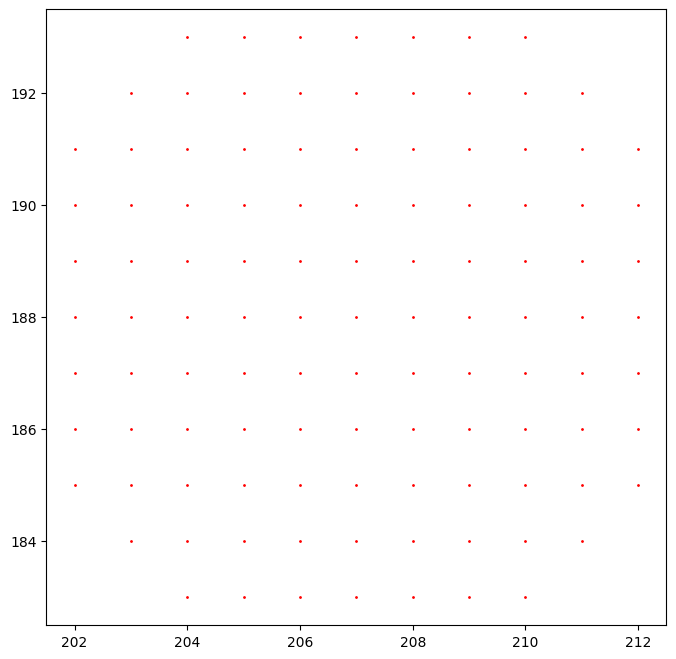

In [17]:
dir(roi)

['__annotations__',
 '__class__',
 '__dataclass_fields__',
 '__dataclass_params__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'arrow_head_size',
 'arrow_style_or_aspect_ratio',
 'autoname',
 'bottom',
 'byteorder',
 'c_position',
 'composite',
 'coordinates',
 'counter_positions',
 'counters',
 'drawoffset',
 'fill_color',
 'float_stroke_width',
 'frombytes',
 'fromfile',
 'frompoints',
 'group',
 'heightd',
 'hexcolor',
 'image_opacity',
 'image_size',
 'integer_coordinates',
 'left',
 'min_int_coord',
 'multi_coordinates',
 'n_coordinates',
 'name',
 'options',
 'overlay_font_size',
 'overlay_label_color',
 'path2coords',
 'plot',
 'position',
 'props',
 'right',
 'roitype',

In [11]:
from PyQt5.QtGui import QPixmap, QPainter

# 論文画像用
dir_asset = "../../optic_figure/assets/fig5"

# view
pixmap_bg = gui.control_manager.view_controls["pri"].layer_bg.pixmap()
pixmap_roi = gui.control_manager.view_controls["pri"].layer_roi.pixmap()

# DPIを300に設定する場合
target_dpi = 1200

# pixmap_bgのDPIを増やす
img_bg = pixmap_bg.toImage()
# 明示的にintに変換
img_bg.setDotsPerMeterX(int(target_dpi * 39.37))  # inch to meter conversion
img_bg.setDotsPerMeterY(int(target_dpi * 39.37))
high_dpi_pixmap_bg = QPixmap.fromImage(img_bg)

# pixmap_roiのDPIを増やす
img_roi = pixmap_roi.toImage()
img_roi.setDotsPerMeterX(int(target_dpi * 39.37))
img_roi.setDotsPerMeterY(int(target_dpi * 39.37))
high_dpi_pixmap_roi = QPixmap.fromImage(img_roi)

# 保存
path_view_bg = os.path.join(dir_asset, "view_bg.png")
path_view_roi = os.path.join(dir_asset, "view_roi.png")

# TIFFとして保存（DPIメタデータを保持）
high_dpi_pixmap_bg.save(path_view_bg.replace(".png", ".tif"), "TIFF")
high_dpi_pixmap_roi.save(path_view_roi.replace(".png", ".tif"), "TIFF")

True